In [2]:
%load_ext autoreload
%autoreload 3 --print

In [154]:
from kpsn.util.simple_density import PointCloudDensity, cloud_kl, cloud_js
from kpsn.util import density as old
import matplotlib.pyplot as plt
import joblib as jl
import numpy as np
from scipy import stats

In [145]:
precomputed = jl.load('../../../data_explore/data/keypts_and_reconstructed.jl')
# Steps at which reconstruction was computed
steps = precomputed['steps']
# Names of sessions to be projected onto reference sessions
nonref_sessions = precomputed['nonref_sessions']
# Names of reference sessions that bodies were projected onto
ref_sessions = precomputed['ref_sessions']
# Aligned keypoints for each session
# dict[session_name, np.array(n_frames, 38)]
keypts = precomputed['keypts']
# Keypoints from each session projected onto a reference session according to
# morph at a step of training
# nested_list<array> (step, ref_sess, nonref_sess, frame, 38)
reconst = precomputed['reconst']

Reloading 'kpsn.util.density'.


In [149]:
K = 15
ref_clouds = {s: PointCloudDensity(k = K).fit(keypts[s]) for s in ref_sessions}

In [17]:

# JSDs between reference sessions
assert len(ref_sessions) == 2
ref_to_ref = cloud_js(ref_clouds[ref_sessions[0]], ref_clouds[ref_sessions[1]])[0]

# # JSDs between reference and non-reference sessions with/without morph
# unmorphed[i, j] = jsd(ref_sessions[i], nonref_sessions[j])
# unmorphed[l, i, j] = jsd(ref_sessions[i], morph_onto_ref[l, i](nonref_sessions[j]))
unmorphed = np.zeros([len(ref_sessions), len(nonref_sessions)])
morphed = np.zeros([len(steps), len(ref_sessions), len(nonref_sessions)])
for i, ref_sess in enumerate(ref_sessions):
    for j, nonref_sess in enumerate(nonref_sessions):
        print(f"Computing JSDs: {ref_sess} <-> {nonref_sess}")
        unmorphed[i, j] = cloud_js(
            ref_clouds[ref_sess],
            PointCloudDensity(k = K).fit(keypts[nonref_sess]))[0]
        
        for l, step in enumerate(steps):
            morphed[l, i, j] = cloud_js(
                ref_clouds[ref_sess],
                PointCloudDensity(k = K).fit(reconst[l][i][j]))[0]

Reloading 'kpsn.util.simple_density'.
Computing JSDs: 3wk_m0.0 <-> 3wk_m0.0
Computing JSDs: 3wk_m0.0 <-> 52wk-3wk_m0.0
Computing JSDs: 3wk_m0.0 <-> 3wk_m0.1
Computing JSDs: 3wk_m0.0 <-> 52wk-3wk_m0.1
Computing JSDs: 3wk_m0.1 <-> 3wk_m0.0
Computing JSDs: 3wk_m0.1 <-> 52wk-3wk_m0.0
Computing JSDs: 3wk_m0.1 <-> 3wk_m0.1
Computing JSDs: 3wk_m0.1 <-> 52wk-3wk_m0.1


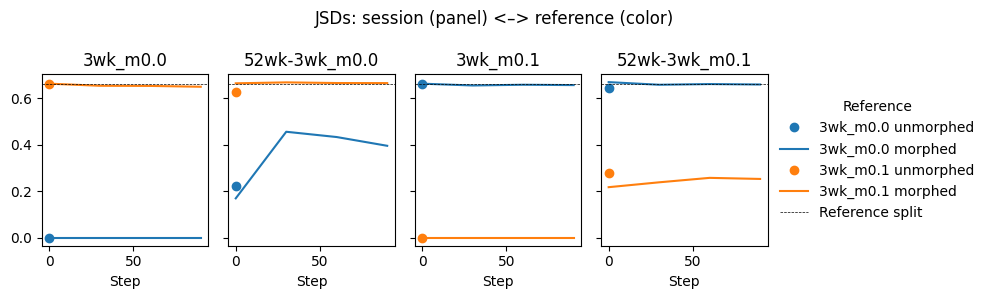

In [18]:

fig, ax = plt.subplots(1, len(nonref_sessions), figsize = (10, 3), sharex=True, sharey=True)
pal = ['C0', 'C1']
for j, nonref_sess in enumerate(nonref_sessions):
    for i, ref_sess in enumerate(ref_sessions):
        ax[j].plot(0, unmorphed[i, j], 'o', color = pal[i], label = f"{ref_sess} unmorphed")
        ax[j].plot(steps, morphed[:, i, j], color = pal[i], label = f"{ref_sess} morphed")
    ax[j].set_title(nonref_sess)
    ax[j].set_xlabel("Step")
    ax[j].axhline(ref_to_ref, ls = '--', color = 'k', lw = 0.5, label = "Reference split")
ax[-1].legend(bbox_to_anchor = (1, 0.5), loc = 'center left', frameon = False, title = "Reference")
fig.suptitle("JSDs: session (panel) <–> reference (color)")
plt.tight_layout()

In [157]:
# KL divergences between some of the distributions which are getting negative
# JSD
ref_sess_tests = ['3wk_m0.0', '3wk_m0.0', '3wk_m0.0', '3wk_m0.1']
nonref_sess_tests = ['3wk_m0.0', '3wk_m0.1', '52wk-3wk_m0.0', '52wk-3wk_m0.1']
step = 1
for ref_sess, nonref_sess in zip(ref_sess_tests, nonref_sess_tests):

    ref_ix = ref_sessions.index(ref_sess)
    nonref_ix = nonref_sessions.index(nonref_sess)


    cloud_a = PointCloudDensity(k = 15).fit(keypts[ref_sess])
    cloud_b = PointCloudDensity(k = 15).fit(reconst[step][ref_ix][nonref_ix])
    calced_jsd = cloud_js(cloud_a, cloud_b)
    print("Test:", ref_sess, nonref_sess, f"(jsd {calced_jsd})")

    kl_ab = cloud_kl(cloud_a, cloud_b)
    kl_ba = cloud_kl(cloud_b, cloud_a)
    print('-> kls:', kl_ab, kl_ba)

    print('-> H_js', old.entropic_jsd(cloud_a, cloud_b))

Reloading 'kpsn.util.density'.
Test: 3wk_m0.0 3wk_m0.0 (jsd -6.229393277054523e-13)
-> kls: 1.944131288294829e-09 -1.9441457266966844e-09
-> H_js 0.5245689315833477
Test: 3wk_m0.0 3wk_m0.1 (jsd 0.21539200611119436)
-> kls: 7.032282201614167 11.331811540098219
density.predict_mixture: n mismatch!
density.predict_mixture: n mismatch!
-> H_js 0.6529128237850852
Test: 3wk_m0.0 52wk-3wk_m0.0 (jsd -0.14313642992359854)
-> kls: -0.46714034578398556 1.7554229693424754
-> H_js 0.5330001157474058
Test: 3wk_m0.1 52wk-3wk_m0.1 (jsd -0.08870790346733662)
-> kls: -0.4639293601127094 1.1834517775273028
-> H_js 0.4742835177127951


In [177]:
# Attempt to reproduce negative JS/KL by shifting

test_offsets = np.linspace(0, 10, 5)
test_offsets = [0, 1, 2]
ref_sess = '3wk_m0.0'

cloud_a = PointCloudDensity(k = 15).fit(keypts[ref_sess][:, :2])

for ofs in test_offsets:
    b_data = cloud_a._tree.data.copy() + ofs
    cloud_b = PointCloudDensity(k = 15).fit(b_data[:, :2])

    kl_ab = cloud_kl(cloud_a, cloud_b)
    kl_ba = cloud_kl(cloud_b, cloud_a)
    jsd = cloud_js(cloud_a, cloud_b)
    ent_jsd = old.entropic_jsd(cloud_a, cloud_b)

    print("Offset:", ofs)
    print("-> kls:", kl_ab, kl_ba)
    print("-> jsd:", jsd)
    print("-> ent_jsd:", ent_jsd)


Reloading 'kpsn.util.density'.
6.395827409566631 6.065432067136568 6.065432067136568
Offset: 0
-> kls: -0.0 -0.0
-> jsd: 0.0
-> ent_jsd: 0.3303953424300632
6.461540958034778 6.065432067136568 6.065432067136568
Offset: 1
-> kls: 0.3903923123840897 0.40389708465186064
-> jsd: 0.09768391152787669
-> ent_jsd: 0.3961088908982102
6.535348760320683 6.065432067136568 6.065432067136568
Offset: 2
-> kls: 1.1220780899352907 1.1112677232421881
-> jsd: 0.2428395240045771
-> ent_jsd: 0.469916693184115


Reloading 'kpsn.util.density'.

>>> offset: 0.0


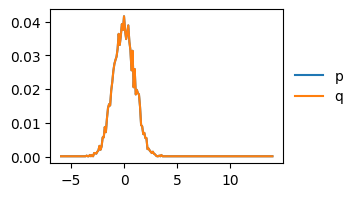

histogram
-> kls 0.0 0.0
-> jsd 0.0
cloud
-> kls:, kl(p|q) = -0.0, kl(q|p) = -0.0
-> jsd: 0.0
-> ent_jsd: -0.02913238927656514

>>> offset: 2.5


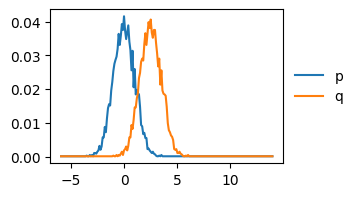

histogram
-> kls 2.5567167157732698 2.5009742187374733
-> jsd 0.6433939560400884
cloud
-> kls:, kl(p|q) = 2.866357563757124, kl(q|p) = 2.782025120325512
-> jsd: 0.45209714200800855
-> ent_jsd: 0.4496897819952843

>>> offset: 5.0


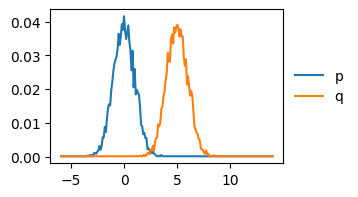

histogram
-> kls 4.593164498920251 4.587696574700021
-> jsd 0.7865194169486317
cloud
-> kls:, kl(p|q) = 5.922441611619956, kl(q|p) = 5.893793820291389
-> jsd: 0.677173664931437
-> ent_jsd: 0.6805771353797414


In [168]:
# Compare measurements to scipy kl and jsd functions

from scipy import special 
from scipy.spatial import distance
test_offsets = np.linspace(0, 5, 3)
N = 5000; n_bin = 200; k = 15
a_data = np.random.randn(N)

bins = np.linspace(-6, 14, n_bin)
a_hist = np.histogram(a_data, bins = bins)[0] + 1
a_hist = a_hist / a_hist.sum()
cloud_a = PointCloudDensity(k = k).fit(a_data.reshape(-1, 1))

for ofs in test_offsets:

    b_data = a_data + ofs
    b_hist = np.histogram(b_data, bins = bins)[0] + 1
    b_hist = b_hist / b_hist.sum()
    print('\n>>> offset:', ofs)

    fig = plt.figure(figsize = (3, 2))
    plt.plot((bins[1:] + bins[:-1]) / 2, a_hist, 'C0', label = "p")
    plt.plot((bins[1:] + bins[:-1]) / 2, b_hist, 'C1', label = "q")
    plt.legend(bbox_to_anchor = (1, 0.5), loc = 'center left', frameon = False)
    plt.show()

    print("histogram")
    print("-> kls", special.rel_entr(a_hist, b_hist).sum(), special.rel_entr(b_hist, a_hist).sum())
    print("-> jsd", distance.jensenshannon(a_hist, b_hist))

    cloud_b = PointCloudDensity(k = k).fit(b_data.reshape(-1, 1))
    kl_ab = cloud_kl(cloud_a, cloud_b)
    kl_ba = cloud_kl(cloud_b, cloud_a)
    jsd = cloud_js(cloud_a, cloud_b)
    ent_js = old.entropic_jsd(cloud_a, cloud_b)

    print("cloud")
    print(f"-> kls:, kl(p|q) = {kl_ab}, kl(q|p) = {kl_ba}")
    print("-> jsd:", jsd)
    print("-> ent_jsd:", ent_js)

### Mixture entropy (1d)


>>> offset: 3


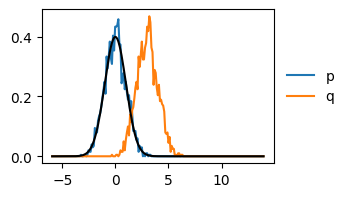

In [187]:
test_offsets = np.linspace(0, 5, 3)
N = 2000; n_bin = 200; k = 15; stddev = 1
a_gauss_data = np.random.randn(N) * stddev

bins = np.linspace(-6, 14, n_bin)
bin_width = bins[1] - bins[0]
bin_centers = (bins[1:] + bins[:-1]) / 2
a_data = a_gauss_data.reshape(-1, 1)
a_hist = np.histogram(a_data, bins = bins, density = True)[0]
a_hist_pdf = a_hist * bin_width
cloud_a = PointCloudDensity(k = k).fit(a_data.reshape(-1, 1))

ofs = 3

b_data = a_data + ofs
b_hist = np.histogram(b_data, bins = bins, density = True)[0]
b_hist_pdf = b_hist * bin_width
cloud_b = PointCloudDensity(k = k).fit(b_data.reshape(-1, 1))

mix_hist = (a_hist + b_hist) / 2
mix_hist_pdf = mix_hist * bin_width

print('\n>>> offset:', ofs)


fig = plt.figure(figsize = (3, 2))
plt.plot(bin_centers, a_hist, 'C0', label = "p")
plt.plot(bin_centers, b_hist, 'C1', label = "q")
plt.plot(bin_centers, stats.norm(scale = stddev).pdf(bin_centers), color = 'k')
plt.legend(bbox_to_anchor = (1, 0.5), loc = 'center left', frameon = False)
plt.show()

In [194]:
from kpsn.util import density as old
eps = 1e-10

# calculate mixture entropy
a_dists, _, mix_dists_a = old.predict_mixture(cloud_a, cloud_b, a_data)
_, b_dists, mix_dists_b = old.predict_mixture(cloud_a, cloud_b, b_data)
normalizer = (cloud_a._k - 1) / cloud_a._n
mix_normalizer = (cloud_a._k - 1) / (cloud_a._n + cloud_b._n)
pdf_a = normalizer / old.ball_volume(a_dists, 1)
pdf_b = normalizer / old.ball_volume(b_dists, 1)
mix_pdf_a = mix_normalizer / old.ball_volume(mix_dists_a, 1)
mix_pdf_b = mix_normalizer / old.ball_volume(mix_dists_b, 1)
a_entropy = -np.mean(np.log(pdf_a))
b_entropy = -np.mean(np.log(pdf_b))
mix_entropy = -np.mean(np.log(np.concatenate([mix_pdf_a, mix_pdf_b]) + eps))

hist_ent_a = -(np.log(a_hist + eps) * a_hist_pdf).sum()
hist_ent_b = -(np.log(b_hist + eps) * b_hist_pdf).sum()
hist_ent_mix = -(np.log(mix_hist + eps) * mix_hist_pdf).sum()

print("closed form")
print("H(a)", np.log(2 * np.pi * np.e * stddev ** 2) / 2)

print("histogram")
print("-> H(a)", hist_ent_a)
print("-> H(b)", hist_ent_b)
print("-> H(mix)", hist_ent_mix)
print("-> JS  ", distance.jensenshannon(a_hist, b_hist))
print("-> JS_H", hist_ent_mix - 0.5 * (hist_ent_a + hist_ent_b))

print("cloud")
print("-> H(a)", a_entropy)
print("-> H(b)", b_entropy)
print("-> H(mix)", mix_entropy)
print("-> JS_H", mix_entropy - 0.5 * (a_entropy + b_entropy))

closed form
H(a) 1.4189385332046727
histogram
-> H(a) 1.395584564983341
-> H(b) 1.3953286934520799
-> H(mix) 1.9319370620411844
-> JS   0.7324482460385727
-> JS_H 0.536480432823474
cloud
-> H(a) 1.3814594043889863
-> H(b) 1.3814594043889865
-> H(mix) 1.9104368343159706
-> JS_H 0.5289774299269843


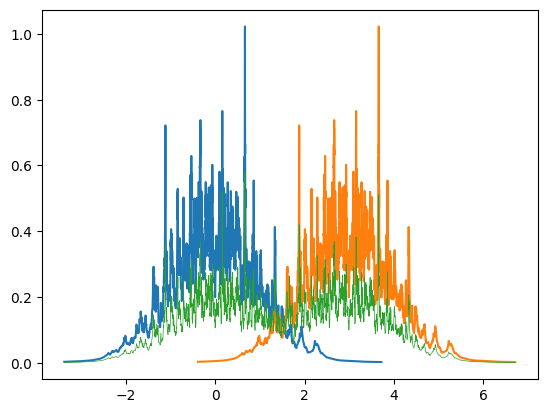

In [144]:
a_pts = cloud_a._tree.data
a_sort = np.argsort(a_pts[:, 0])

b_pts = cloud_b._tree.data
b_sort = np.argsort(b_pts[:, 0])

mix_pts = np.concatenate([a_pts, b_pts])
mix_pdf = np.concatenate([mix_pdf_a, mix_pdf_b])
mix_sort = np.argsort(mix_pts[:, 0])

plt.plot(a_pts[a_sort], pdf_a[a_sort])
plt.plot(b_pts[b_sort], pdf_a[b_sort])
plt.plot(mix_pts[mix_sort], mix_pdf[mix_sort], lw = 0.5)

plt.show()

### Mixture entropy (2d)

In [196]:
a_data = keypts['3wk_m0.0'][:, :2]
b_data = a_data
cloud_a = PointCloudDensity(k = 15).fit(a_data)
cloud_b = PointCloudDensity(k = 15).fit(b_data)

# calculate mixture entropy
a_dists, _, mix_dists_a = old.predict_mixture(cloud_a, cloud_b, a_data)
_, b_dists, mix_dists_b = old.predict_mixture(cloud_a, cloud_b, b_data)
normalizer = (cloud_a._k - 1) / cloud_a._n
mix_normalizer = (cloud_a._k - 1) / (cloud_a._n + cloud_b._n)
pdf_a = normalizer / old.ball_volume(a_dists, 1)
pdf_b = normalizer / old.ball_volume(b_dists, 1)
mix_pdf_a = mix_normalizer / old.ball_volume(mix_dists_a, 1)
mix_pdf_b = mix_normalizer / old.ball_volume(mix_dists_b, 1)
a_entropy = -np.mean(np.log(pdf_a))
b_entropy = -np.mean(np.log(pdf_b))
mix_entropy = -np.mean(np.log(np.concatenate([mix_pdf_a, mix_pdf_b])))

print(a_entropy, b_entropy, mix_entropy)
print(mix_entropy - 0.5 * (a_entropy + b_entropy))


6.065432067136568 6.065432067136568 6.395827409566631
0.3303953424300632


In [181]:
keypts['3wk_m0.0'].shape

(8981, 38)